In [1343]:
import warnings
warnings.filterwarnings("ignore")

In [1344]:
import pandas as pd
from datetime import datetime


def parser(x):
  return datetime.strptime(x, "%Y-%m-%d")


data = pd.read_csv('Sales_Data.csv', header=0, parse_dates=[0], index_col=0, date_format=parser)
data.head()

,sales
date,
2013-01-01,1742
2013-01-02,1808
2013-01-03,1887
2013-01-04,1983
2013-01-05,2087


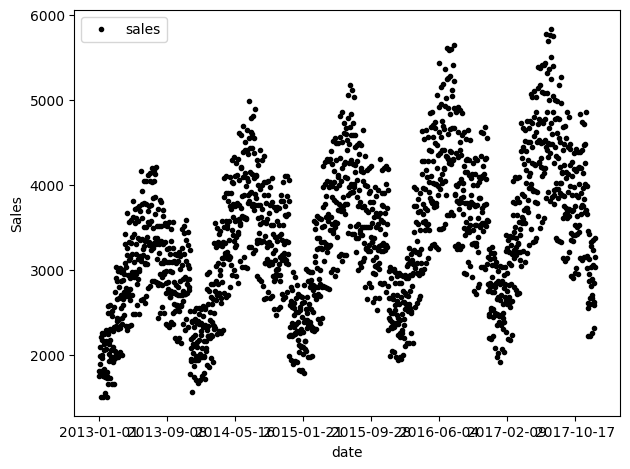

In [1345]:
import matplotlib.pyplot as plt
%matplotlib inline
data = data.astype(float)
data
data.plot(style='k.',ylabel='Sales')
# adjust auto space size
plt.tight_layout()
plt.show()

In [1346]:
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from scipy.linalg import pinv
data = np.array(data)
data = np.reshape(data, (-1, 1))
data

array([[1742.],
       [1808.],
       [1887.],
       ...,
       [3025.],
       [3151.],
       [3370.]], shape=(1826, 1))

In [1347]:
m = 14  # number of lags, pred at 8th day
per = (1736 - m)/1826  # percentage of data used for training
print(per)
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]
mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

0.9430449069003286


In [1348]:
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])

for i in range(1, (d_train.shape[0]-m)):
  l = np.array([d_train[j][0] for j in range(i, i+m)])
  X_train = np.vstack([X_train, l])
  y_train = np.vstack([y_train, d_train[i+m]])
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])
for i in range(1, (d_test.shape[0]-m)):
  l = np.array([d_test[j][0] for j in range(i, i+m)])
  X_test = np.vstack([X_test, l])
  y_test = np.vstack([y_test, d_test[i+m]])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1708, 14)
(1708, 1)
(90, 14)
(90, 1)


In [1349]:
import scipy.stats as stats
input_size = X_train.shape[1]
hidden_size = 200  # no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1
w_hi = 1
b_lo = -1
b_hi = 1
# initialising input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma, size=[input_size, hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma, size=[hidden_size])


def relu(x):  # hidden layer activation function
  return np.maximum(x, 0, x)

In [1350]:
def hidden_nodes(X):
  G = np.dot(X, input_weights)
  G = G + biases
  H = relu(G)
  return H


output_weights = np.dot(pinv(hidden_nodes(X_train)), y_train)


def predict(X):
  out = hidden_nodes(X)
  out = np.dot(out, output_weights)
  return out


prediction = predict(X_test)

In [1351]:
correct = 0
total = X_test.shape[0]
y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
mse = mean_squared_error(y_test, prediction)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i, j in zip(y_test, prediction):
  mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i, j in zip(y_test, prediction):
  mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)

Test MSE: 29879.004
Test RMSE: 172.855
Test MAPE: 2.733
Test MPE: -0.950


([<matplotlib.axis.XTick at 0x27b99ac4c90>,
 [Text(0, 0, '2017-10-02'),
  Text(20, 0, '2017-10-22'),
  Text(40, 0, '2017-11-11'),
  Text(60, 0, '2017-12-01'),
  Text(80, 0, '2017-12-21')])

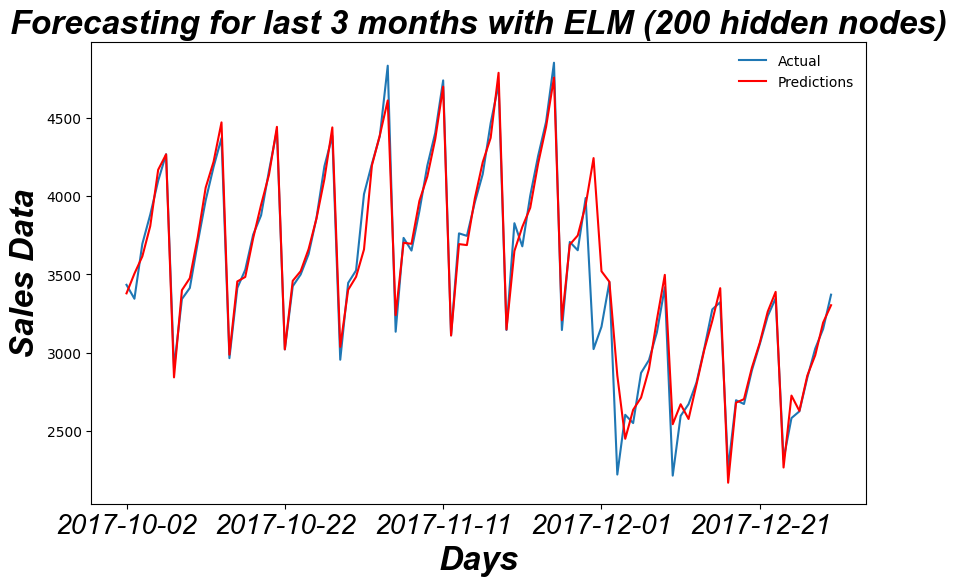

In [1352]:
# plot forecasts against actual outcomes
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y_test, label='Actual')
ax.plot(prediction, color='red', label='Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('Sales Data', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title(f'Forecasting for last 3 months with ELM ({hidden_size} hidden nodes)', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.xticks([0, 20, 40, 60, 80], ['2017-10-02', '2017-10-22', '2017-11-11', '2017-12-01', '2017-12-21'], fontname="Arial", fontsize=20, style='italic')
# plt.yticks(fontname="Arial", fontsize = 22, style='italic')

In [1353]:
# x = [1110, 1762, 3764, 4144, 3124, 1000, 3456, 3456, 5252, 3333, 3452, 2315, 3215, 3678] # 14d
x = [1110, 1762, 3764, 4144, 3124, 1000, 3456] # 7d
prediction = predict(x)
print(prediction)

ValueError: shapes (7,) and (14,200) not aligned: 7 (dim 0) != 14 (dim 0)